In [1]:
import os
import time
import subprocess
import glob
import sys
import shutil
import pandas
import numpy as np
import Bio.Alphabet.IUPAC
from Bio import SeqIO
import scipy.stats
import random
import math
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(font_scale=2, style='ticks', palette='colorblind')

sys.path.append('scripts/')
import design_utils

import pyrosetta
flags = [
    '-mute all', '-mute core', '-mute protocols',
    '-ignore_unrecognized_res', '-crystal_refine',
    '-read_only_ATOM_entries'
]
pyrosetta.init(extra_options=' '.join(flags))
# pyrosetta.init('-crystal_refine -mute all')

# Initiate directories
resultsdir = 'results/'

In [2]:
pandas.set_option('display.max_columns', None)

In [3]:
e_function_dict = {
    'beta16_cart' : {
        'cart_weights_file' : \
            '/home/haddox/2019/optE_eval/data/beta_nov16_cart.wts',
        'flags_file' : \
            '/home/haddox/2019/optE_eval/data/flags_beta16', 
        'extra_args' : []
    }
}

Compute interatomic distances

In [4]:
len(glob.glob('/home/haddox/2019/optE_eval_dist/data/beta_nov16_natives_validation/*.pdb'))

54

In [5]:
flags_f = e_function_dict['beta16_cart']['flags_file']
weights_f = e_function_dict['beta16_cart']['cart_weights_file']

output_dir = os.path.join(
    resultsdir,
    'interatomic_distances/'
)
if not os.path.isdir(output_dir):
    os.makedirs(output_dir)

pdb_files = glob.glob('data/mod/*.pdb')
pdb_files += glob.glob('/home/haddox/2019/optE_eval_dist/data/beta_nov16_natives_validation/*.pdb')
pdb_files += glob.glob('results/cartesian_relax_cr_final/*/beta16_cart/*_mod_0001.pdb')
njobs = 0
for pdb_file in pdb_files:
    pdb_basename = os.path.basename(pdb_file).replace('.pdb', '')
    output_file = os.path.join(output_dir, f'{pdb_basename}.csv')
    cmd = [
        'python',
        'scripts/compute_energies_between_atom_pairs.py',
        f'--pdb_file {pdb_file}',
        f'--flags_f {flags_f}',
        f'--weights_f {weights_f}',
        f'--output_file {output_file}'
    ]
    cmd = 'source activate high_throughput_design_for_E_function_opt\n'\
        + ' '.join(cmd)
    sbatch_file = os.path.join(output_dir,f'{pdb_basename}.sbatch')
    if not os.path.isfile(sbatch_file):
        print(pdb_basename)
        raise ValueError()
        design_utils.WriteSbatchFile(
            sbatch_file,
            command=cmd,
            queue_type='cpu',
            memory='2g'
        )
        ! sbatch {sbatch_file}
        njobs += 1
        if njobs > 100:
            raise ValueError('test')

For a few, compute energies using an expanded distance cutoff

In [6]:
flags_f = e_function_dict['beta16_cart']['flags_file']
weights_f = e_function_dict['beta16_cart']['cart_weights_file']

output_dir = os.path.join(
    resultsdir,
    'interatomic_distances_expanded/'
)
if not os.path.isdir(output_dir):
    os.makedirs(output_dir)

pdb_files = glob.glob('results/cartesian_relax_cr_final/D_3_212_*/beta16_cart/*_mod_0001.pdb')
njobs = 0
for pdb_file in pdb_files:
    pdb_basename = os.path.basename(pdb_file).replace('.pdb', '')
    output_file = os.path.join(output_dir, f'{pdb_basename}.csv')
    cmd = [
        'python',
        'scripts/compute_energies_between_atom_pairs.py',
        f'--pdb_file {pdb_file}',
        f'--flags_f {flags_f}',
        f'--weights_f {weights_f}',
        f'--output_file {output_file}',
        '--expanded_dist_cutoff'
    ]
    cmd = 'source activate high_throughput_design_for_E_function_opt\n'\
        + ' '.join(cmd)
    sbatch_file = os.path.join(output_dir,f'{pdb_basename}.sbatch')
    if not os.path.isfile(sbatch_file):
        print(pdb_basename)
        raise ValueError()
        design_utils.WriteSbatchFile(
            sbatch_file,
            command=cmd,
            queue_type='cpu',
            memory='2g'
        )
        ! sbatch {sbatch_file}
        njobs += 1
        if njobs > 100:
            raise ValueError('test')

Analyze expanded distance distributions

In [7]:
fs = [
    'results/interatomic_distances_expanded/D_3_212_xtal_mod_0001.csv',
    'results/interatomic_distances_expanded/D_3_212_design_mod_0001.csv'
]
dfs = []
for f in fs:
    
    # Read in data
    df = pandas.read_csv(f)
    df['pdb'] = os.path.basename(f).replace('_mod_0001.csv', '')
    dfs.append(df)
df = pandas.concat(dfs)

In [8]:
df.columns.values

array(['res_j_n', 'res_j_pdb_n', 'res_j_name', 'res_j_ss', 'res_j_chain',
       'atom_j_n', 'atom_j_name', 'atom_j_type_name', 'atom_j_bb',
       'lj_atr', 'lj_rep', 'fa_solv', 'fa_elec', 'atom_j_lj_radius',
       'atom_j_lj_wdepth', 'atom_j_lk_dgfree', 'd', 'res_i_n',
       'res_i_pdb_n', 'res_i_name', 'res_i_ss', 'res_i_chain', 'atom_i_n',
       'atom_i_name', 'atom_i_type_name', 'atom_i_bb', 'atom_i_lj_radius',
       'atom_i_lj_wdepth', 'atom_i_lk_dgfree', 'o', 'd-o', 'e', 'lj',
       'lj_rep_weighted', 'lj_weighted', 'est_lj_energy',
       'est_rosetta_lj_energy', 'est_weighted_rosetta_lj_energy',
       'seq_dist', 'both_atoms_bb', 'atom_pair', 'aliphatic_C_C',
       'aliphatic_H_H', 'aliphatic_C_H', 'pdb_file', 'pdb', 'pair_id'],
      dtype=object)

In [9]:
design_data = df[
    (df['res_i_pdb_n'] == 17) &
    (df['res_j_pdb_n'] == 215) &
    (df['pdb'] == 'D_3_212_design')
][['res_i_pdb_n', 'atom_i_name', 'res_j_pdb_n', 'atom_j_name', 'fa_elec', 'd', 'lj', 'fa_solv']]
print(design_data['fa_elec'].sum())
# design_data.sort_values('fa_elec')

-5.286973279352184


In [10]:
xtal_data = df[
    (df['res_i_pdb_n'] == 22) &
    (df['res_j_pdb_n'] == 220) &
    (df['pdb'] == 'D_3_212_xtal')
][['res_i_pdb_n', 'atom_i_name', 'res_j_pdb_n', 'atom_j_name', 'fa_elec', 'd']]
print(xtal_data['fa_elec'].sum())
# xtal_data.sort_values('fa_elec')

-0.1403948687264107


In [11]:
-0.1403948687264107 - -5.286973279352184

5.146578410625773

Read in data

In [12]:
fs = glob.glob(os.path.join(
    resultsdir,
    'interatomic_distances/*.csv'
))
# fs = [
#     'results/interatomic_distances/DHD127_xtal_mod.csv',
#     'results/interatomic_distances/DHD127_design_mod_0001.csv'
# ]
dfs = []
for f in fs:
    
    # Read in data
    df = pandas.read_csv(f)
    
    # Define atom pairs of interest
    aas = ['VAL', 'LEU', 'ILE', 'ALA', 'MET', 'PHE', 'TYR', 'TRP']
    atom_type_names = ['CH1', 'CH2', 'CH3', 'CH0', 'aroC']
    df['hydrophobic_C_C'] = (
        (df['res_i_name'].isin(aas)) &
        (df['res_j_name'].isin(aas)) &
        (df['atom_i_type_name'].isin(atom_type_names)) &
        (df['atom_j_type_name'].isin(atom_type_names))
    )
    df['C_Obb'] = (
        (
            (df['atom_i_type_name'] == 'OCbb') &
            (df['atom_j_type_name'].isin(atom_type_names) & df['res_j_name'].isin(aas))
        ) |
        (
            (df['atom_j_type_name'] == 'OCbb') &
            (df['atom_i_type_name'].isin(atom_type_names) & df['res_i_name'].isin(aas))
        )
    )
    
    # Subset to atom pairs of interest
    df = df[
        (df['hydrophobic_C_C'] == True) |
        (df['C_Obb'] == True)
    ]
    
    # Get metadata
    def classify_pdb(pdb):
        if '_xtal_mod.pdb' in pdb:
            return ('xtal', pdb.replace('_xtal_mod.pdb', ''))
        elif '_xtal_mod_0001.pdb' in pdb:
            return ('relaxed_xtal', pdb.replace('_xtal_mod_0001.pdb', ''))
        elif '_design_mod.pdb' in pdb:
            return ('design', pdb.replace('_design_mod.pdb', ''))
        elif '_design_mod_0001.pdb' in pdb:
            return ('relaxed_design', pdb.replace('_design_mod_0001.pdb', ''))
        elif '_clean_0001.pdb' in pdb:
            return ('native', pdb.replace('_clean_0001.pdb', ''))
    df['class'], df['design_id'] = zip(*df['pdb'].apply(lambda x: classify_pdb(x)))
    
    df['clashing'] = df['d-o'] < 0
    
    dfs.append(df)
    
df = pandas.concat(dfs)

In [13]:
#f = 'results/interatomic_distances/MC2_7_design_mod.csv'
#f = 'results/interatomic_distances/DHD127_xtal_mod.csv'
#f = '/home/haddox/2019/rosetta_feature_space_geometry/results/atom_pair_energies/zibo_heterodimers_xtals_relaxed/DHD_127_xtal_6DLM_0001.csv'
#df = pandas.read_csv(f)

# df['hydrophobic_C_C'] = (
#     (df['res_i_name'].isin(aas)) &
#     (df['res_j_name'].isin(aas)) &
#     (df['atom_i_type_name'].isin(atom_type_names)) &
#     (df['atom_j_type_name'].isin(atom_type_names))
# )
# df['C_Obb'] = (
#     (
#         (df['atom_i_type_name'] == 'OCbb') &
#         (df['atom_j_type_name'].isin(atom_type_names) & df['res_j_name'].isin(aas))
#     ) |
#     (
#         (df['atom_j_type_name'] == 'OCbb') &
#         (df['atom_i_type_name'].isin(atom_type_names) & df['res_i_name'].isin(aas))
#     )
# )

# df = df[
#     (df['hydrophobic_C_C'] == True) |
#     (df['C_Obb'] == True)
# ]

For each design/xtal pair, identify sites in the design where at least one atom is not resolved in the crystal structure

In [17]:
df.head()

,res_j_n,res_j_pdb_n,res_j_name,res_j_ss,res_j_chain,atom_j_n,atom_j_name,atom_j_type_name,atom_j_bb,lj_atr,lj_rep,fa_solv,fa_elec,atom_j_lj_radius,atom_j_lj_wdepth,atom_j_lk_dgfree,d,res_i_n,res_i_pdb_n,res_i_name,res_i_ss,res_i_chain,atom_i_n,atom_i_name,atom_i_type_name,atom_i_bb,atom_i_lj_radius,atom_i_lj_wdepth,atom_i_lk_dgfree,o,d-o,e,lj,lj_rep_weighted,lj_weighted,est_lj_energy,est_rosetta_lj_energy,est_weighted_rosetta_lj_energy,seq_dist,both_atoms_bb,atom_pair,aliphatic_C_C,aliphatic_H_H,aliphatic_C_H,pdb_file,pdb,pair_id,hydrophobic_C_C,C_Obb,class,design_id,clashing
27,2,2,TRP,E,A,5,CB,CH2,False,-0.079571,0.0,0.233443,0.311648,2.011760,0.062642,-2.5518,3.864734,1,1,THR,L,A,4,O,OCbb,True,1.54058,0.142417,-9.5292,3.552340,0.312394,0.094453,-0.079571,0.0,-0.079571,-0.079571,-0.079571,-0.079571,1,False,CH2:OCbb,False,False,False,data/mod/LHD29_xtal_mod.pdb,LHD29_xtal_mod.pdb,1_4_2_5_LHD29_xtal_mod.pdb,False,True,xtal,LHD29,False
28,2,2,TRP,E,A,6,CG,CH0,False,-0.084035,0.0,0.079615,0.055752,2.011760,0.062642,1.2487,3.799538,1,1,THR,L,A,4,O,OCbb,True,1.54058,0.142417,-9.5292,3.552340,0.247198,0.094453,-0.084035,0.0,-0.084035,-0.084035,-0.084035,-0.084035,1,False,CH0:OCbb,False,False,False,data/mod/LHD29_xtal_mod.pdb,LHD29_xtal_mod.pdb,1_4_2_6_LHD29_xtal_mod.pdb,False,True,xtal,LHD29,False
29,2,2,TRP,E,A,7,CD1,aroC,False,-0.078295,0.0,0.131520,-0.055879,2.016441,0.068775,2.2228,3.938150,1,1,THR,L,A,4,O,OCbb,True,1.54058,0.142417,-9.5292,3.557021,0.381129,0.098968,-0.078295,0.0,-0.078295,-0.078295,-0.078295,-0.078295,1,False,OCbb:aroC,False,False,False,data/mod/LHD29_xtal_mod.pdb,LHD29_xtal_mod.pdb,1_4_2_7_LHD29_xtal_mod.pdb,False,True,xtal,LHD29,False
128,4,4,TRP,E,A,11,CE3,aroC,False,-0.080492,0.0,0.135119,0.189685,2.016441,0.068775,2.2228,3.908754,2,2,TRP,E,A,4,O,OCbb,True,1.54058,0.142417,-9.5292,3.557021,0.351733,0.098968,-0.080492,0.0,-0.080492,-0.080492,-0.080492,-0.080492,2,False,OCbb:aroC,False,False,False,data/mod/LHD29_xtal_mod.pdb,LHD29_xtal_mod.pdb,2_4_4_11_LHD29_xtal_mod.pdb,False,True,xtal,LHD29,False
129,4,4,TRP,E,A,13,CZ3,aroC,False,-0.091889,0.0,0.156769,0.226286,2.016441,0.068775,2.2228,3.746400,2,2,TRP,E,A,4,O,OCbb,True,1.54058,0.142417,-9.5292,3.557021,0.189379,0.098968,-0.091889,0.0,-0.091889,-0.091889,-0.091889,-0.091889,2,False,OCbb:aroC,False,False,False,data/mod/LHD29_xtal_mod.pdb,LHD29_xtal_mod.pdb,2_4_4_13_LHD29_xtal_mod.pdb,False,True,xtal,LHD29,False


In [65]:
data = (
    df[df['class'].isin(['xtal', 'relaxed_design'])][['design_id', 'pdb_file', 'class']]
    .drop_duplicates()
    .sort_values('design_id')
    .pivot(index='design_id', columns='class', values='pdb_file')
    .reset_index()
)
data.head()

class,design_id,relaxed_design,xtal
0,5L6HC3_1,results/cartesian_relax_cr_final/5L6HC3_1_desi...,data/mod/5L6HC3_1_xtal_mod.pdb
1,6AYYA,results/cartesian_relax_cr_final/6AYYA_design_...,data/mod/6AYYA_xtal_mod.pdb
2,BB1,results/cartesian_relax_cr_final/BB1_design_mo...,data/mod/BB1_xtal_mod.pdb
3,BBM2nHm0589,results/cartesian_relax_cr_final/BBM2nHm0589_d...,data/mod/BBM2nHm0589_xtal_mod.pdb
4,CAV1,results/cartesian_relax_cr_final/CAV1_design_m...,data/mod/CAV1_xtal_mod.pdb


In [76]:
data['design_id'].unique()

array(['5L6HC3_1', '6AYYA', 'BB1', 'BBM2nHm0589', 'CAV1', 'DHD127',
       'DHD131', 'DHR4', 'DHR76', 'D_3_212', 'D_3_633', 'LHD29', 'MC2_7',
       'RPB_PLP3_R6–PLPx6', 'THR1', 'THR2', 'WSHC6'], dtype=object)

In [83]:
# Get files
data = (
    df[df['class'].isin(['xtal', 'relaxed_design'])][['design_id', 'pdb_file', 'class']]
    .drop_duplicates()
    .sort_values('design_id')
    .pivot(index='design_id', columns='class', values='pdb_file')
    .reset_index()
)

# Iterate over designs and identify sites where the number of heavy atoms
# differs between the design and crystal
for (i, row) in data.iterrows():

    # if row['design_id'] not in ['CAV1', 'MC2_7', 'DHD127', 'DHD131', '6AYYA', 'D_3_212', 'D_3_633']:
    if row['design_id'] not in ['D_3_633']:
        continue

    # Read in poses from files
    # design_file = f'data/mod/{design_id}_design_mod.pdb'
    # xtal_file = f'data/mod/{design_id}_xtal_mod.pdb'
    design = pyrosetta.pose_from_pdb(row['relaxed_design'])
    xtal = pyrosetta.pose_from_pdb(row['xtal'])
    assert design.size() == xtal.size()
    
    # Iterate over sites and compare
    print('#------------------------------------')
    print(row['design_id'], design.size())
    for res_n in range(1, design.size() + 1):
        dres = design.residue(res_n)
        xres = xtal.residue(res_n)
        assert dres.name1() == xres.name1()
        nheavy_design = dres.nheavyatoms()
        nheavy_xtal = xres.nheavyatoms()
        assert nheavy_xtal > 1
        # print(res_n, dres.name1(), nheavy_design, nheavy_xtal)
        if nheavy_design != nheavy_xtal:
            print(res_n, dres.name1(), nheavy_design, nheavy_xtal)
    print('\n')

#------------------------------------
D_3_633 436
220 R 12 11




In [111]:
row['xtal']

'data/mod/WSHC6_xtal_mod.pdb'

In [104]:
res_n = 93
dres = design.residue(res_n)
xres = xtal.residue(res_n)

In [105]:
design.pdb_info().chain(res_n), design.pdb_info().number(res_n), dres.name1()

('A', 101, 'K')

In [106]:
xtal.pdb_info().chain(res_n), xtal.pdb_info().number(res_n), xres.name1()

('A', 101, 'K')

In [113]:
xres.has_missing_atoms()

AttributeError: 'pyrosetta.rosetta.core.conformation.Residue' object has no attribute 'has_missing_atoms'

In [112]:
xres.nheavyatoms()

9

In [110]:
for atom_n in range(1, xres.natoms() + 1):
    if not xres.atom_type(atom_n).is_hydrogen():
        atom_type = xres.atom_type(atom_n)
        atom_xyz = xres.xyz(atom_n)
        print(atom_type.name(), xres.atom_name(atom_n), atom_xyz)

Nbb  N         14.62900000000000       3.209000000000000       28.22000000000000
CAbb  CA        13.19700000000000       2.999000000000000       28.40400000000000
CObb  C         12.78700000000000       3.266000000000000       29.84700000000000
OCbb  O         11.72100000000000       3.840000000000000       30.10300000000000
CH2  CB        12.80618275019604       1.576611047418811       27.99969038238665
CH2  CG        12.87001273667683       1.308365348312610       26.50192708325494
CH2  CD        12.49018732997302     -0.1294997961871438       26.18133977259061
CH2  CE        12.56395156058319     -0.4022126219381299       24.68621491637378
Nlys  NZ        12.23399432346521      -1.816474024649620       24.36147143893660


In [14]:
o_dict = {
    'aliphatic_C_C' : 2.01 + 2.01,
    'hydrophobic_C_C' : 2.01 + 2.01,
    'C_Obb' : 2.01 + 1.54,
}
title_dict = {
    'hydrophobic_C_C' : 'C:C',
    'C_Obb' : 'C:OCbb'
}

In [15]:
df['design_id'].unique()

array(['LHD29', '2h3l', 'MC2_7', '2ab0', 'DHR76', '2fi1', '1wc2',
       'D_3_633', '2dfb', 'DHD131', 'DHR4', 'D_3_212',
       'RPB_PLP3_R6–PLPx6', 'WSHC6', '2h5c', '5L6HC3_1', '3dke', '2nwd',
       '2oml', '2igd', 'THR2', '6AYYA', '1rw1', 'DHD127', 'CAV1',
       'BBM2nHm0589', 'THR1', '2aqm', '2axw', '3d4e', '2bv4', '1u07',
       '1uz3', '3f2z', '3hp4', '1rg8', '1rwy', '3ess', '1eb6', '2ic6',
       '2a28', '3hyn', '2bwf', '2bt9', '1h4a', '1h4x', '1l3k', '1c5e',
       '2car', 'BB1', '2cal', '1uow', '2c2u', '2v1m', '3ich', '2d8d',
       '2nr7', '1kq6', '1mn8', '2hhg', '3gbw', '2bzv', '2gud', '1xod',
       '2fhz', '2dko', '1sfh', '3co1', '2chh', '1agy', '3cx2'],
      dtype=object)

In [16]:
df['class'].unique()

array(['xtal', 'native', 'relaxed_xtal', 'design', 'relaxed_design'],
      dtype=object)

5L6HC3_1 hydrophobic_C_C 
design 3.402 
xtal 3.463 
natives 3.145


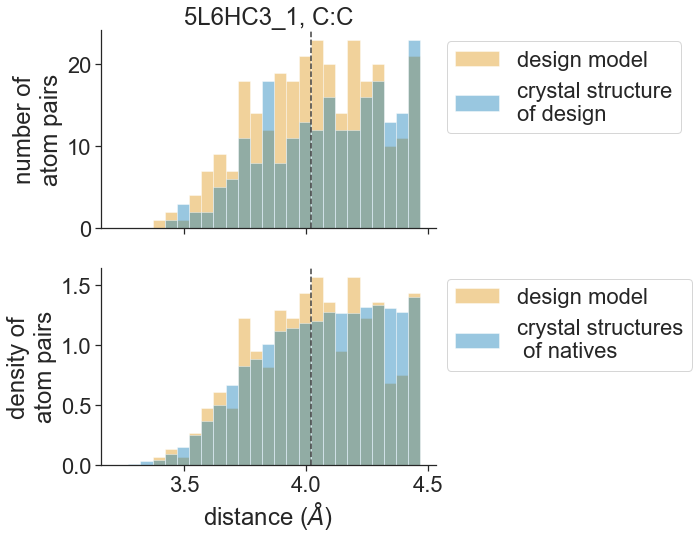

5L6HC3_1 C_Obb 
design 2.981 
xtal 3.054 
natives 2.895


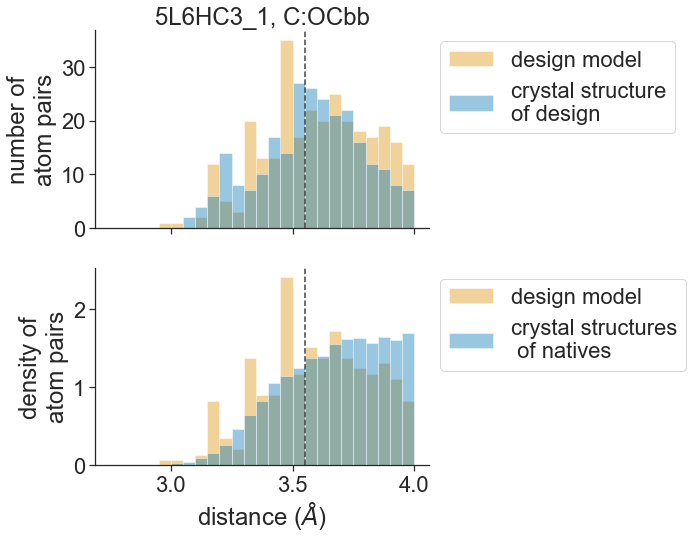

6AYYA hydrophobic_C_C 
design 3.192 
xtal 2.693 
natives 3.145


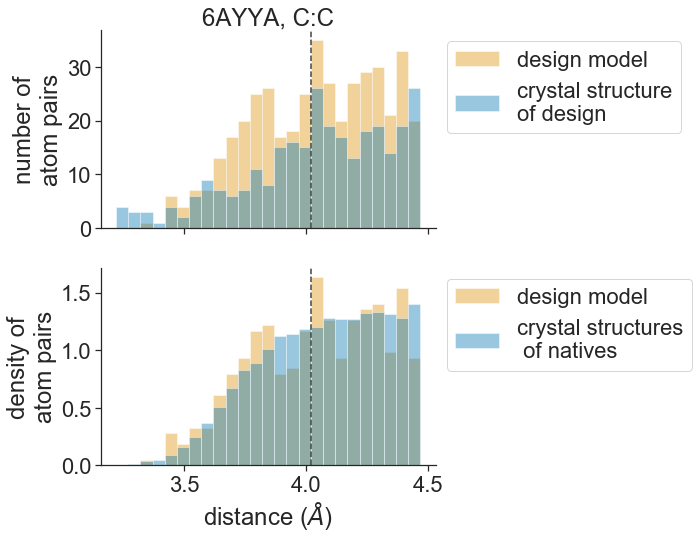

6AYYA C_Obb 
design 3.116 
xtal 2.872 
natives 2.895


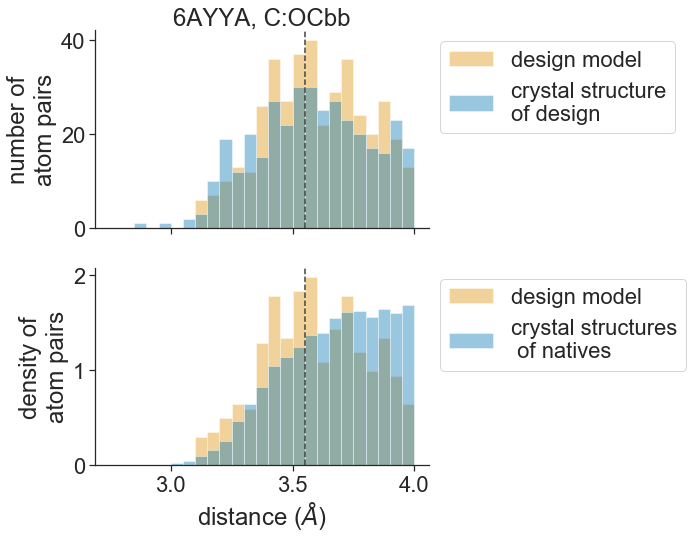

BB1 hydrophobic_C_C 
design 3.288 
xtal 3.226 
natives 3.145


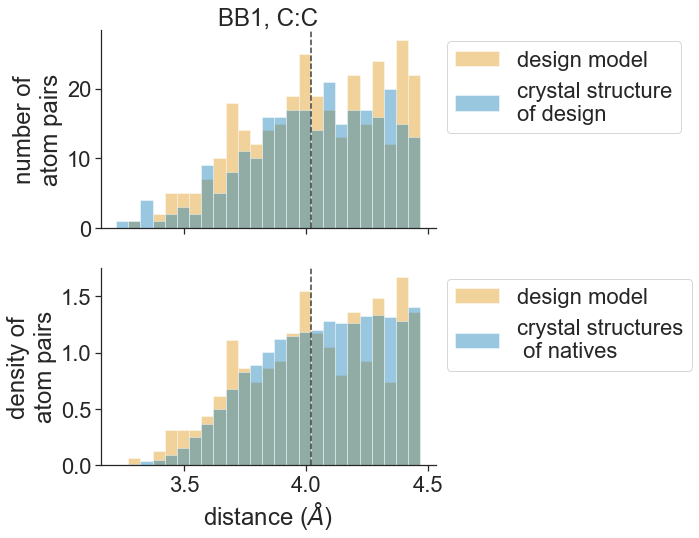

BB1 C_Obb 
design 3.143 
xtal 3.211 
natives 2.895


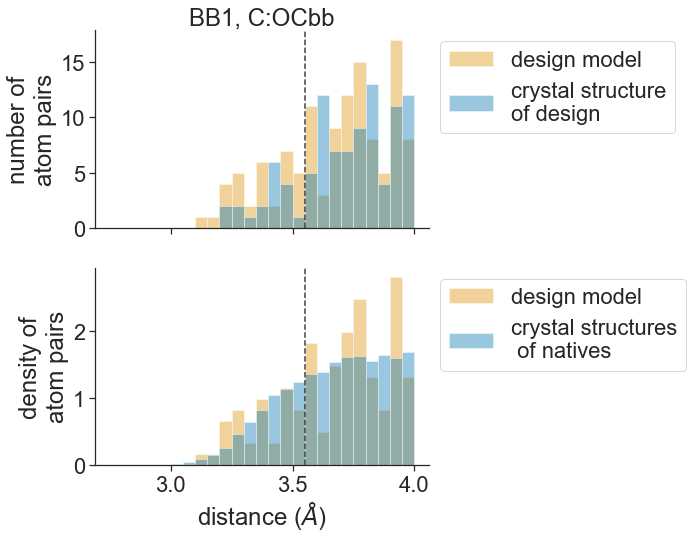

BBM2nHm0589 hydrophobic_C_C 
design 3.293 
xtal 3.199 
natives 3.145


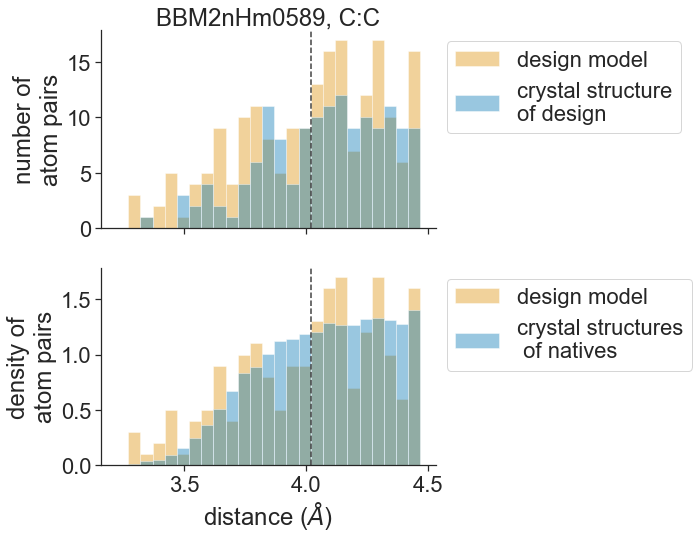

BBM2nHm0589 C_Obb 
design 2.961 
xtal 3.091 
natives 2.895


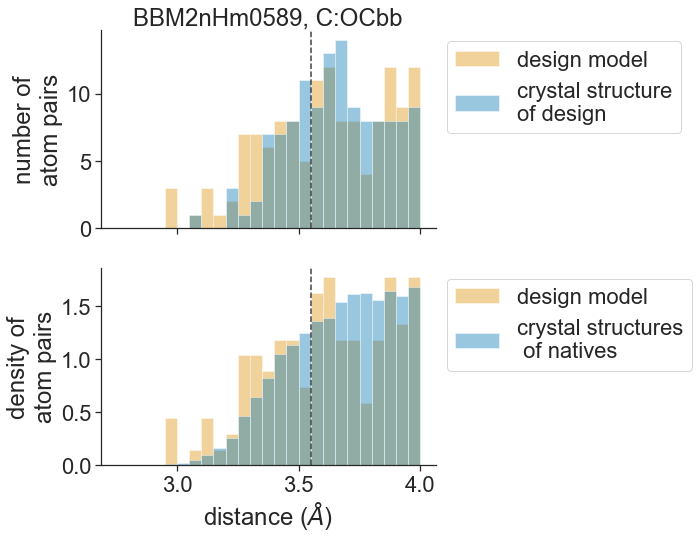

CAV1 hydrophobic_C_C 
design 3.163 
xtal 3.207 
natives 3.145


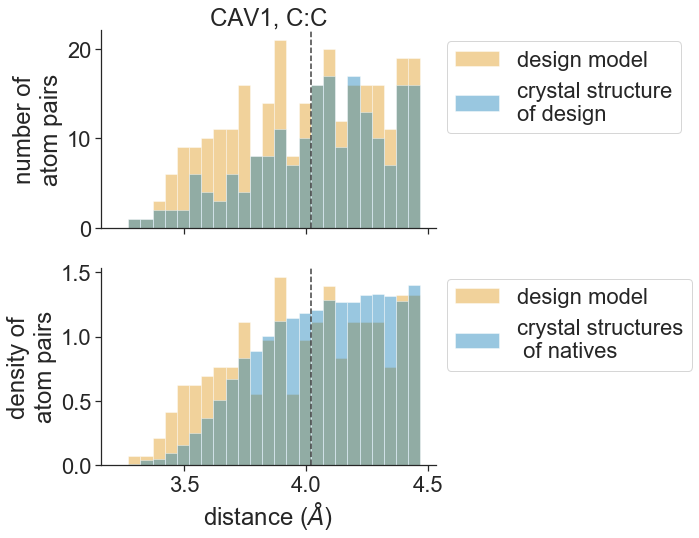

CAV1 C_Obb 
design 3.115 
xtal 3.062 
natives 2.895


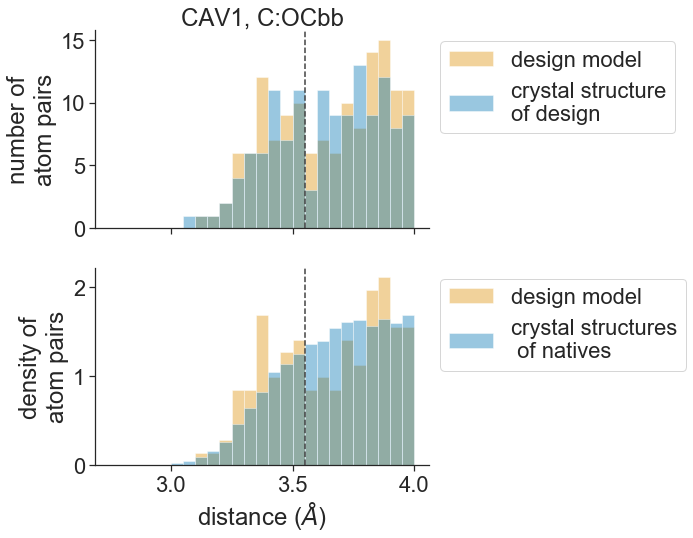

DHD127 hydrophobic_C_C 
design 3.325 
xtal 3.357 
natives 3.145


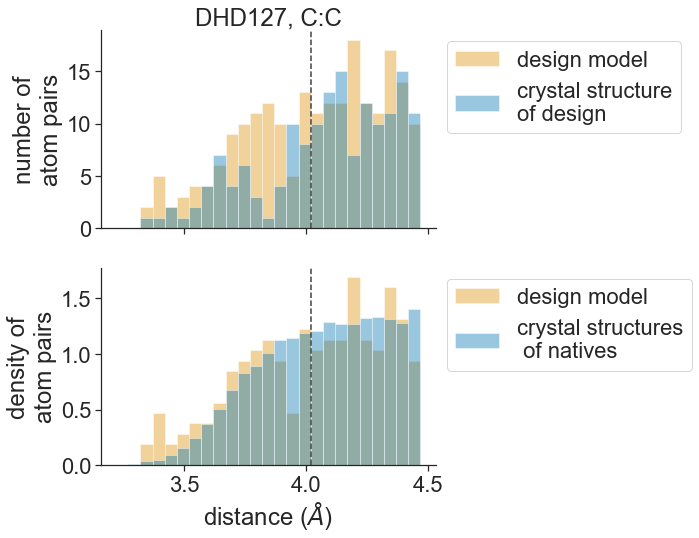

DHD127 C_Obb 
design 3.026 
xtal 3.116 
natives 2.895


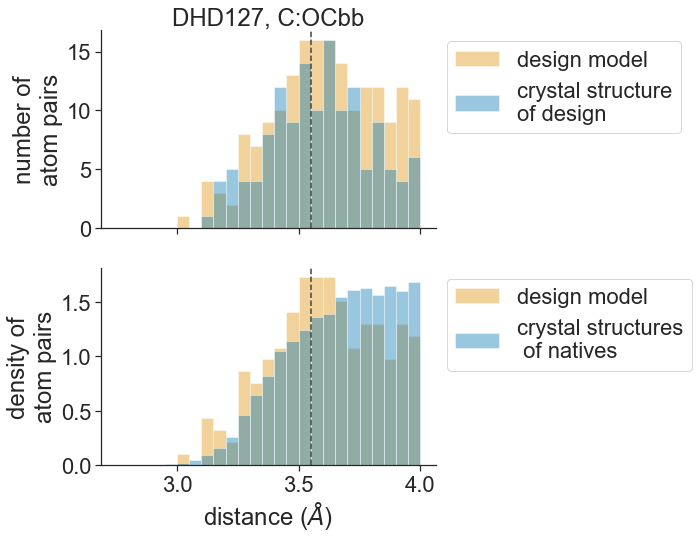

DHD131 hydrophobic_C_C 
design 3.3 
xtal 3.18 
natives 3.145


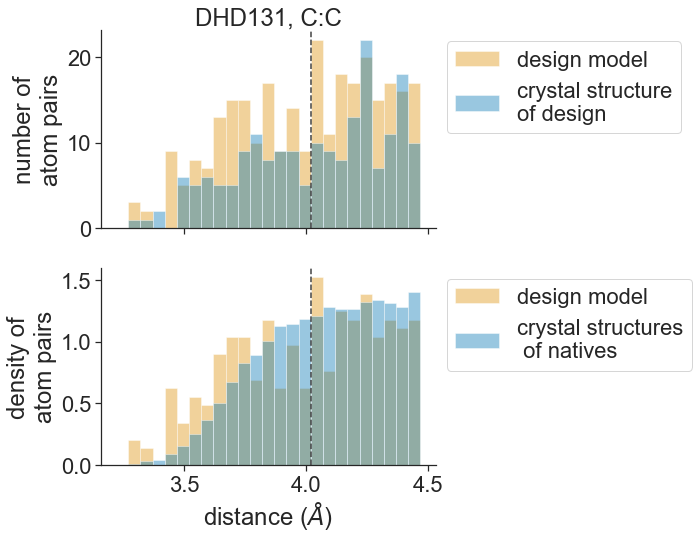

DHD131 C_Obb 
design 2.979 
xtal 2.535 
natives 2.895


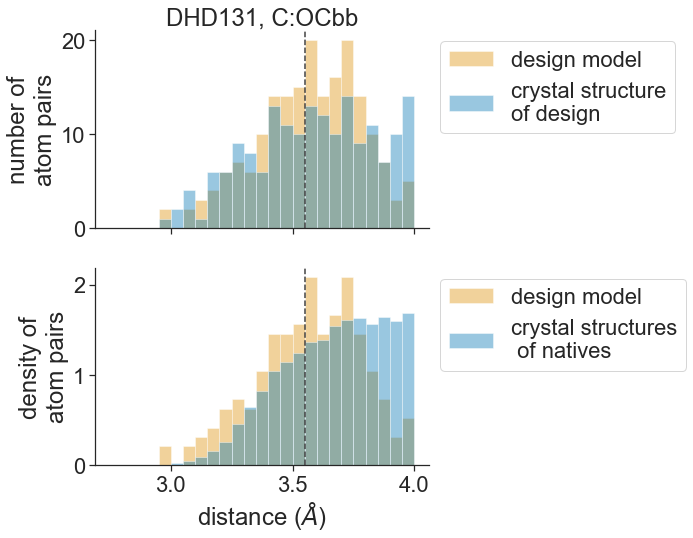

DHR4 hydrophobic_C_C 
design 3.378 
xtal 3.349 
natives 3.145


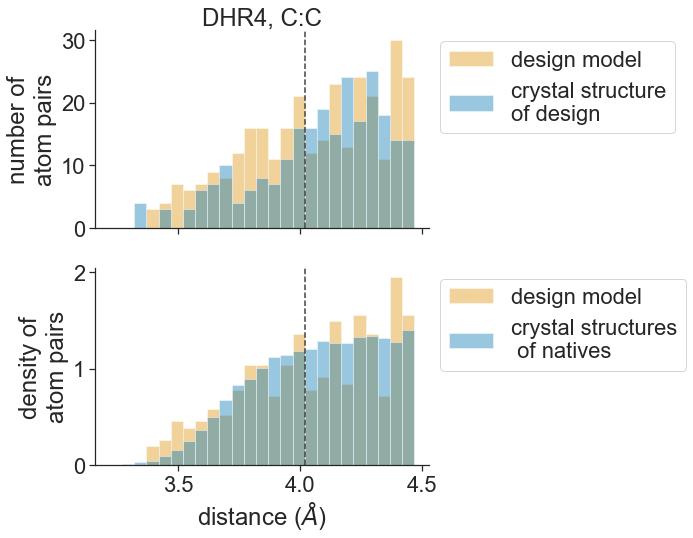

DHR4 C_Obb 
design 3.042 
xtal 3.108 
natives 2.895


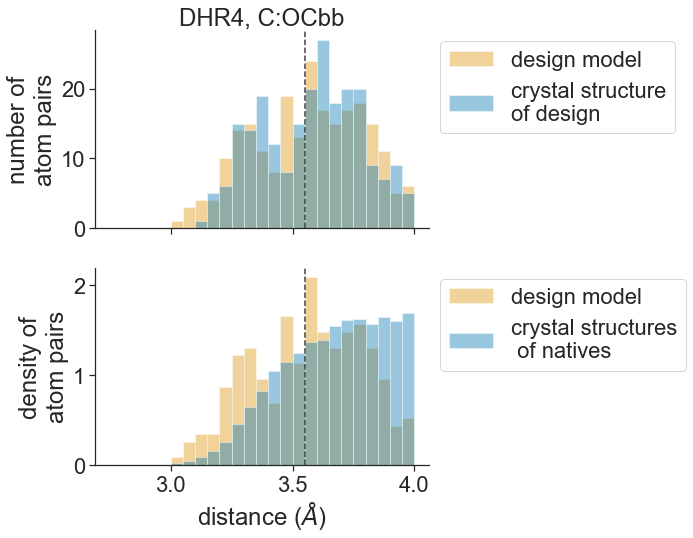

DHR76 hydrophobic_C_C 
design 3.205 
xtal 3.151 
natives 3.145


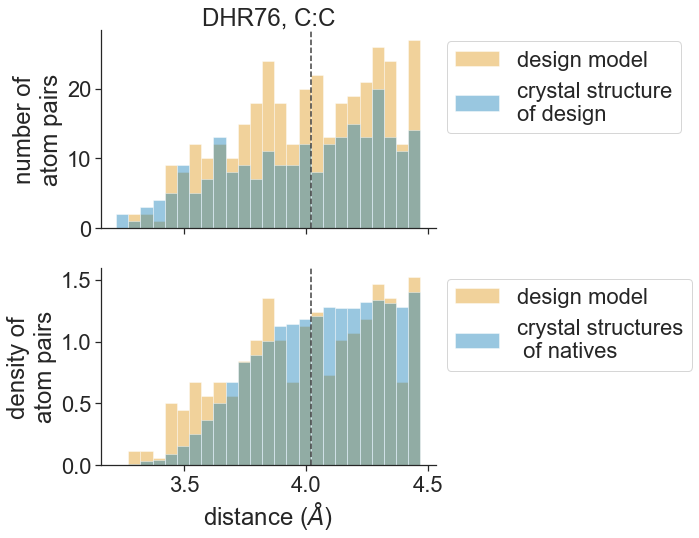

DHR76 C_Obb 
design 2.952 
xtal 2.944 
natives 2.895


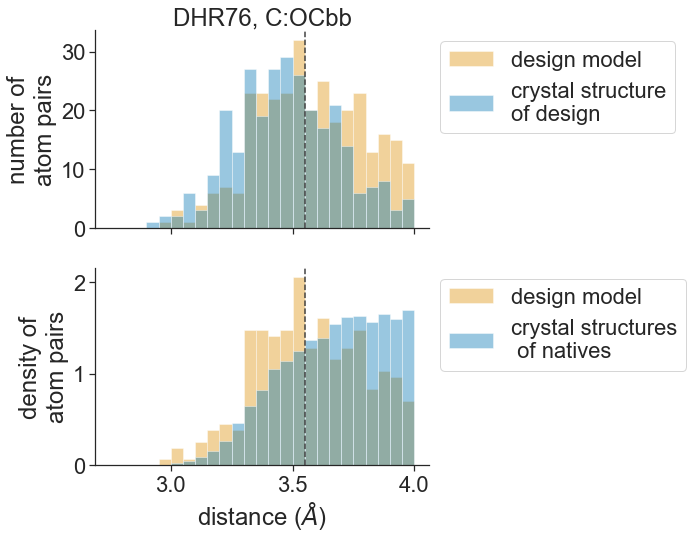

D_3_212 hydrophobic_C_C 
design 3.253 
xtal 3.108 
natives 3.145


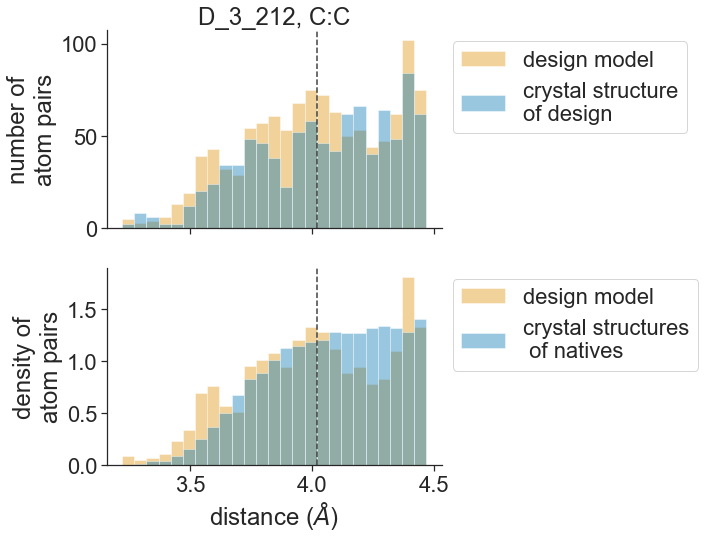

D_3_212 C_Obb 
design 2.86 
xtal 3.029 
natives 2.895


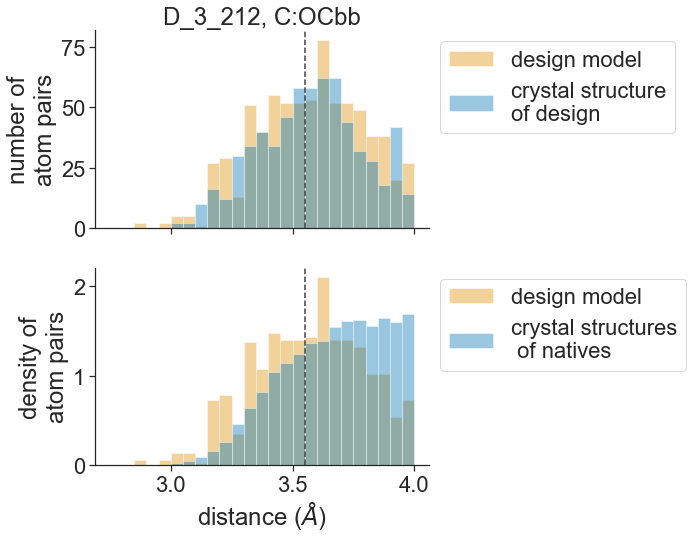

D_3_633 hydrophobic_C_C 
design 3.236 
xtal 1.395 
natives 3.145


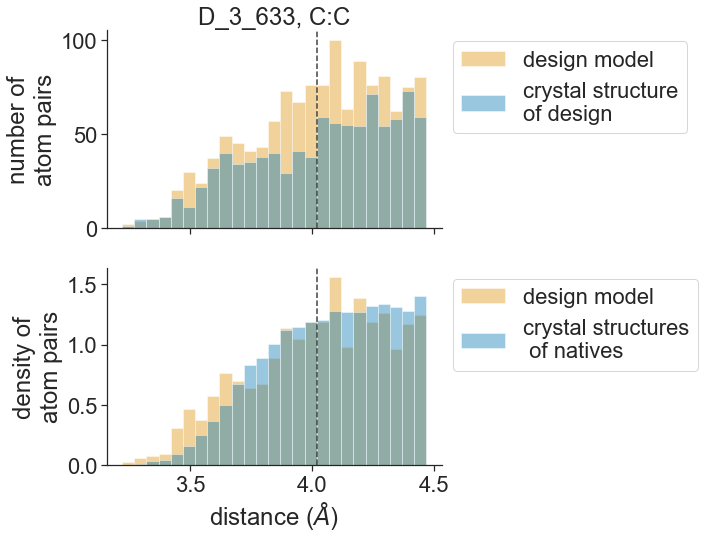

D_3_633 C_Obb 
design 2.955 
xtal 2.691 
natives 2.895


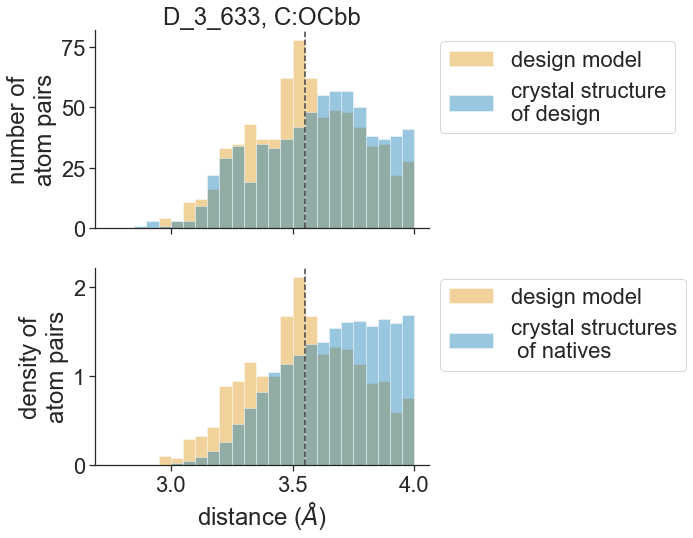

LHD29 hydrophobic_C_C 
design 3.196 
xtal 3.464 
natives 3.145


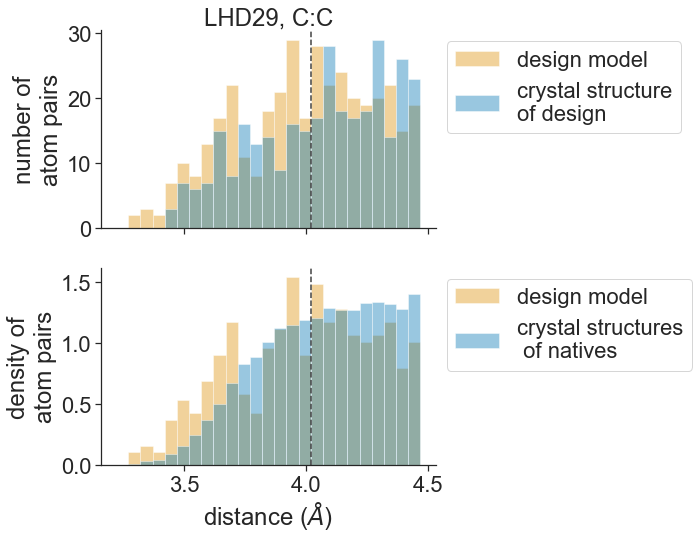

LHD29 C_Obb 
design 2.997 
xtal 3.122 
natives 2.895


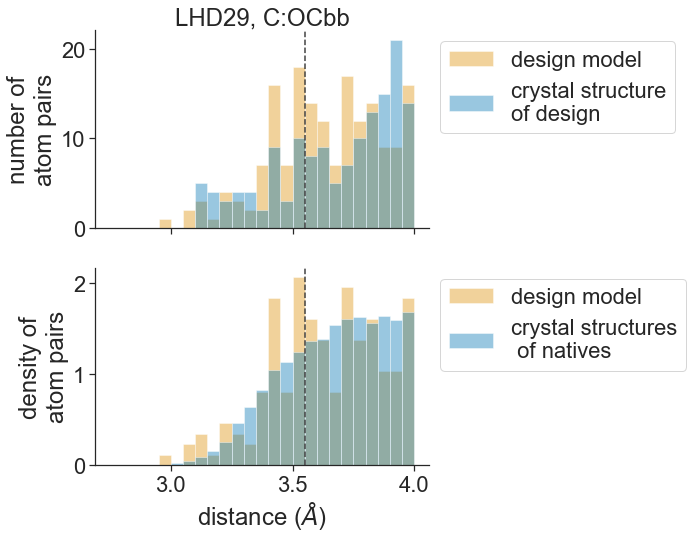

MC2_7 hydrophobic_C_C 
design 3.237 
xtal 3.49 
natives 3.145


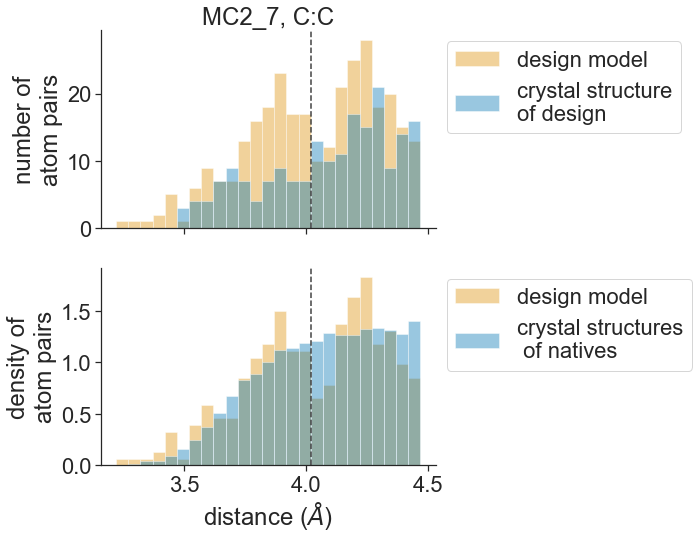

MC2_7 C_Obb 
design 2.903 
xtal 3.005 
natives 2.895


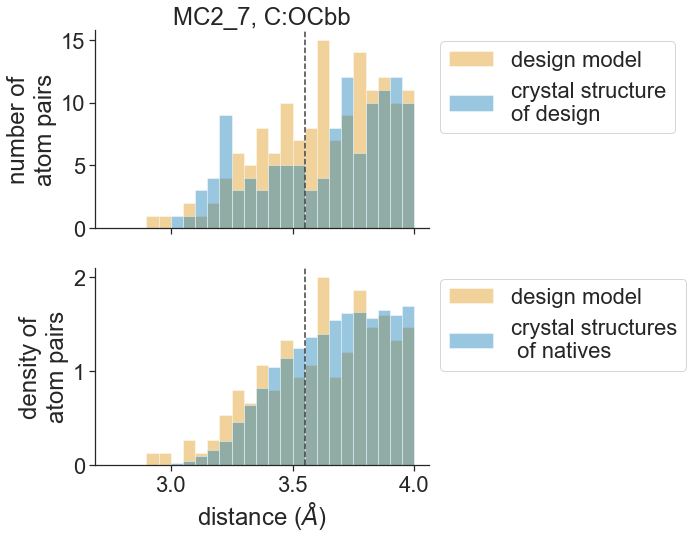

RPB_PLP3_R6–PLPx6 hydrophobic_C_C 
design 3.307 
xtal 3.365 
natives 3.145


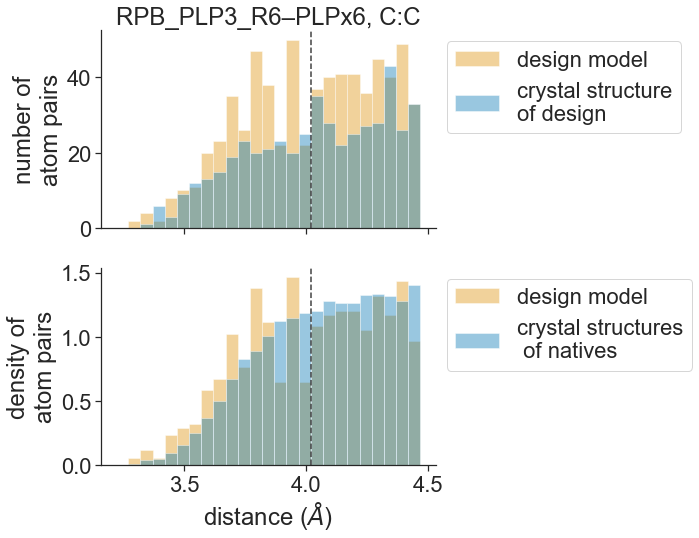

RPB_PLP3_R6–PLPx6 C_Obb 
design 2.961 
xtal 2.94 
natives 2.895


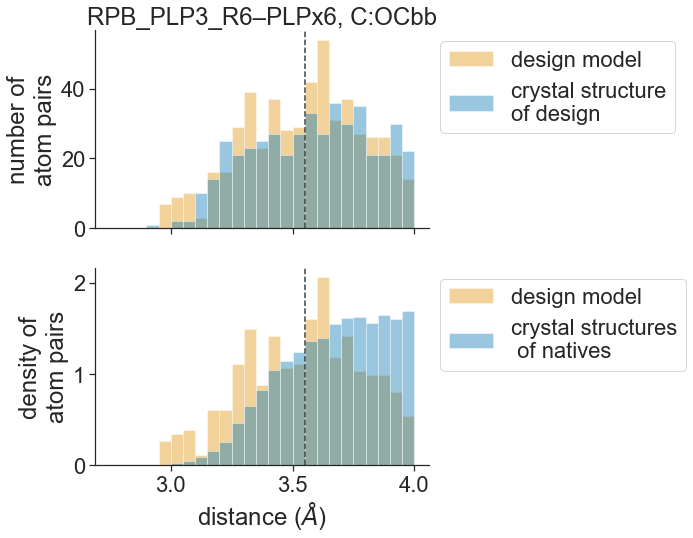

THR1 hydrophobic_C_C 
design 3.188 
xtal 3.515 
natives 3.145


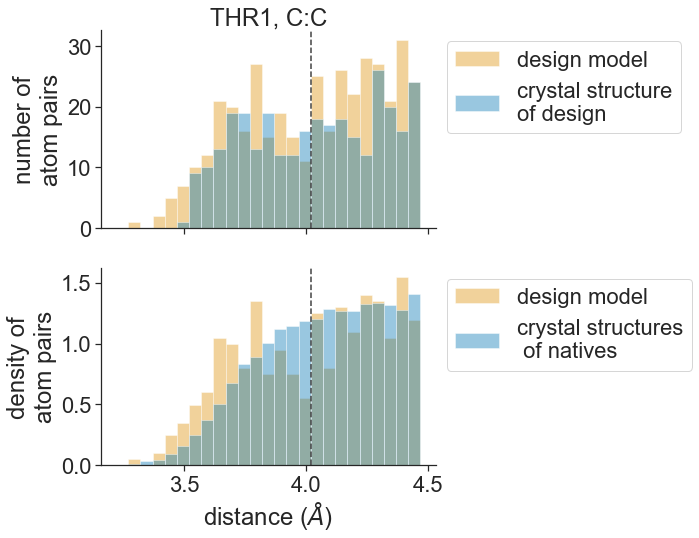

THR1 C_Obb 
design 2.814 
xtal 3.075 
natives 2.895


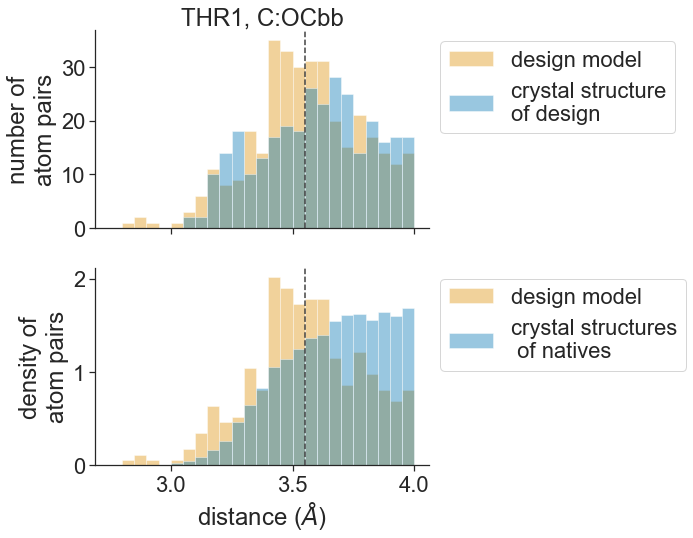

THR2 hydrophobic_C_C 
design 3.338 
xtal 3.517 
natives 3.145


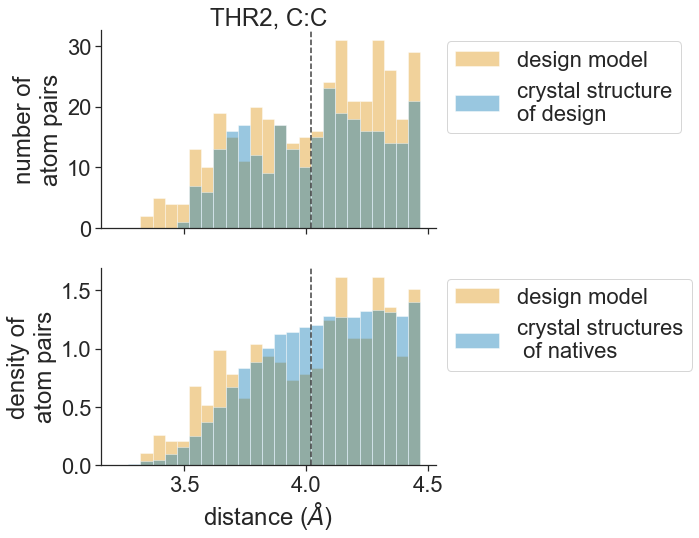

THR2 C_Obb 
design 2.924 
xtal 3.016 
natives 2.895


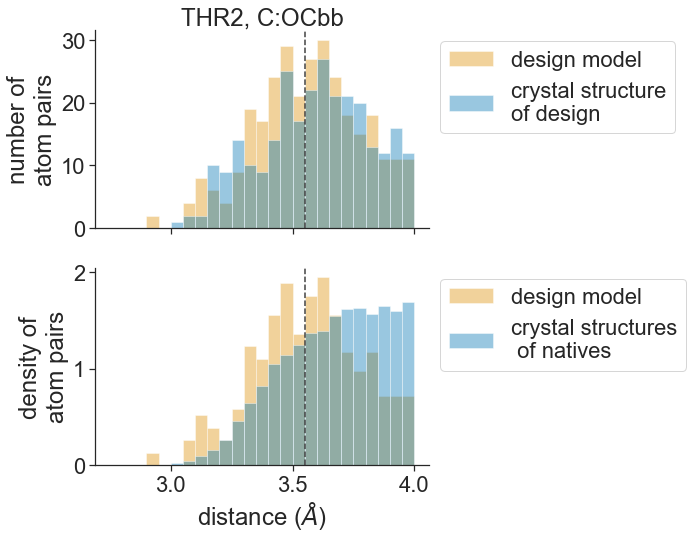

WSHC6 hydrophobic_C_C 
design 3.4 
xtal 2.808 
natives 3.145


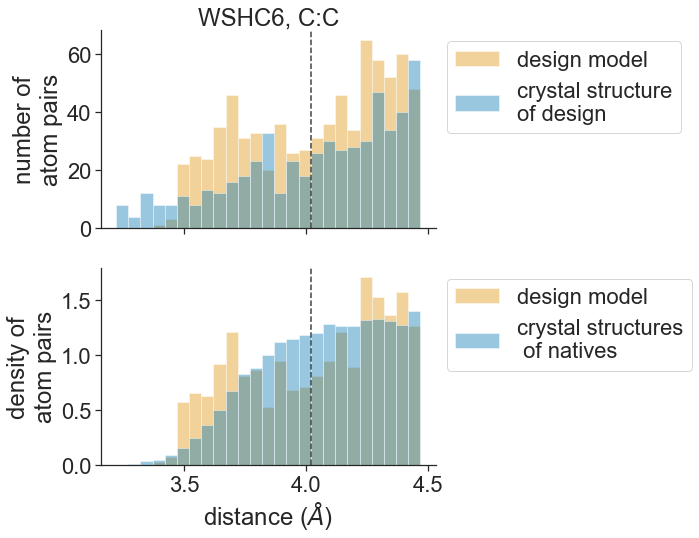

WSHC6 C_Obb 
design 3.085 
xtal 2.696 
natives 2.895


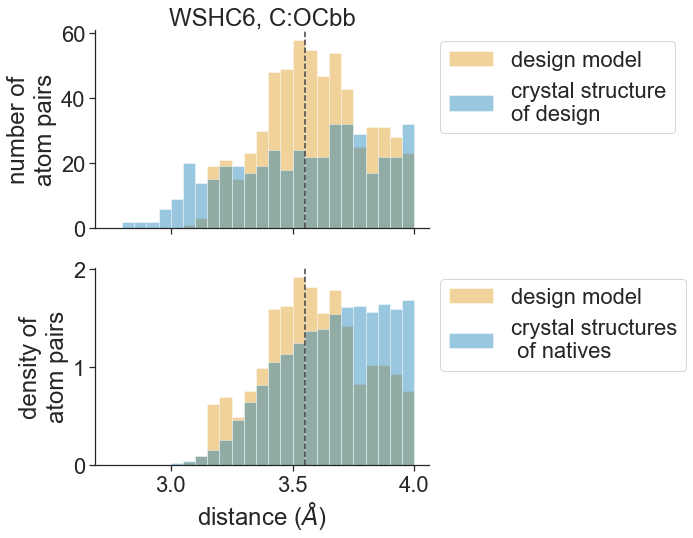

In [33]:
(design_id, pair_type) = ('DHD127', 'hydrophobic_C_C')
#(design_id, pair_type) = ('MC2_7', 'C_Obb')
#(design_id, pair_type) = ('MC2_7', 'hydrophobic_C_C')

design_ids = sorted(df[df['class'] == 'xtal']['design_id'].unique())
pair_types = ['hydrophobic_C_C', 'C_Obb']

output_dir = 'results/distance_distribution_plots/'
if not os.path.isdir(output_dir):
    os.makedirs(output_dir)

for design_id in design_ids:
    for pair_type in pair_types:

        (fig, axs) = plt.subplots(nrows=2, figsize=[6,8], sharex=True)
        o = o_dict[pair_type]
        max_d = o + 0.5
        bins = np.arange(o-0.8, max_d, 0.05)
        (xtal_color, design_color) = ('#0173b2', '#de8f05')
        
        # Plot data for design vs. xtal
        design_data = df[
            (df['design_id'] == design_id) &
            (df['class'] == 'relaxed_design') &
            (df[pair_type] == True)
        ]
        sns.distplot(
            design_data['d'], kde=False, bins=bins,
            label='design model', color=design_color, ax=axs[0]
        )

        xtal_data = df[
            (df['design_id'] == design_id) &
            (df['class'] == 'xtal') &
            (df[pair_type] == True)
        ]
        sns.distplot(
            xtal_data['d'], kde=False, bins=bins,
            label='crystal structure\nof design', color=xtal_color, ax=axs[0]
        )
        axs[0].set(ylabel='number of\natom pairs', xlabel='', title=f'{design_id}, {title_dict[pair_type]}')
        axs[0].legend(bbox_to_anchor=(1,1))

        # Plot data for design vs. native xtal
        sns.distplot(
            design_data['d'], kde=False, bins=bins, norm_hist=True,
            label='design model', color=design_color, ax=axs[1]
        )

        native_data = df[
            (df['class'] == 'native') &
            (df[pair_type] == True)
        ]
        sns.distplot(
            native_data['d'], kde=False, bins=bins, norm_hist=True,
            label='crystal structures\n of natives', color=xtal_color, ax=axs[1]
        )

        for i in [0, 1]:
            axs[i].axvline(o, ls='--', c='0.25')

        axs[1].set(xlabel='distance ($\AA$)', ylabel='density of\natom pairs')
        axs[1].legend(bbox_to_anchor=(1,1))

        print(
            design_id, pair_type,
            '\ndesign', round(design_data['d'].min(), 3),
            '\nxtal', round(xtal_data['d'].min(), 3),
            '\nnatives', round(native_data['d'].min(), 3)
        )
        
        sns.despine()
        pair_type_name = pair_type.replace(':', '_')
        output_f = os.path.join(output_dir, f'{design_id}_{pair_type_name}.png')
        plt.savefig(output_f, dpi=300, bbox_inches='tight')
        plt.show()

In [11]:
design_id = 'MC2_7'
pair_type = 'hydrophobic_C_C'
xtal_data = df[
    (df['design_id'] == design_id) &
    (df['class'] == 'xtal') &
    (df[pair_type] == True)
]

In [12]:
xtal_data[['res_i_pdb_n', 'res_j_pdb_n', 'd']].sort_values('d').head()

,res_i_pdb_n,res_j_pdb_n,d
1352,23,58,3.490232
2671,36,38,3.499469
1390,23,57,3.513439
868,15,81,3.539459
4092,60,64,3.543753


In [13]:
design_data = df[
    (df['design_id'] == design_id) &
    (df['class'] == 'relaxed_design') &
    (df[pair_type] == True)
]
design_data[['res_i_pdb_n', 'res_j_pdb_n', 'd']].sort_values('d').head()

,res_i_pdb_n,res_j_pdb_n,d
3134,36,38,3.236653
1122,15,102,3.292604
1483,18,36,3.361929
2180,26,53,3.382042
632,11,83,3.414353


Plot ratios of numbers of clashing atom pairs

hydrophobic_C_C 0.6678848545085148


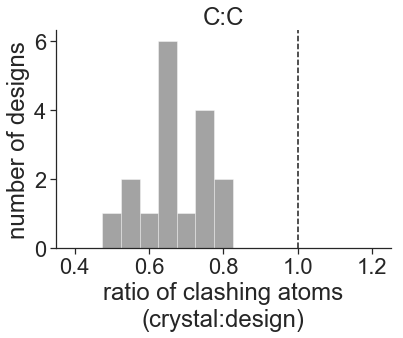

class,relaxed_design,xtal,ratio
design_id,,,
MC2_7,145.0,71.0,0.489655
CAV1,146.0,78.0,0.534247
DHD127,97.0,54.0,0.556701
DHD131,139.0,83.0,0.597122
DHR4,137.0,86.0,0.627737
DHR76,176.0,115.0,0.653409
6AYYA,188.0,123.0,0.654255
RPB_PLP3_R6–PLPx6,322.0,215.0,0.667702
5L6HC3_1,133.0,89.0,0.669173


C_Obb 0.8351805029371145


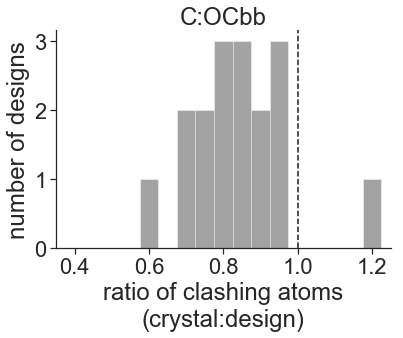

class,relaxed_design,xtal,ratio
design_id,,,
BB1,33.0,19.0,0.575758
LHD29,65.0,44.0,0.676923
THR1,173.0,124.0,0.716763
D_3_633,372.0,276.0,0.741935
BBM2nHm0589,52.0,40.0,0.769231
WSHC6,268.0,214.0,0.798507
THR2,143.0,115.0,0.804196
RPB_PLP3_R6–PLPx6,246.0,199.0,0.808943
MC2_7,53.0,44.0,0.830189


In [22]:
for pair_type in ['hydrophobic_C_C', 'C_Obb']:
    
    # Compute ratios
    data = (
        df[
            (df['class'].isin(['relaxed_design', 'xtal'])) &
            (df[pair_type] == True)
        ]
        .groupby(['design_id', 'class'], as_index=False)[['clashing']].sum()
        .pivot_table(index='design_id', columns='class', values='clashing')
        .assign(ratio=lambda x: x['xtal'] / x['relaxed_design'])
        .sort_values('ratio')
    )
    print(pair_type, data['ratio'].mean())
    
    # Plot data
    plt.figure(figsize=[6,4])
    bins = np.arange(0.375, 1.25, 0.05)
    sns.distplot(data['ratio'], bins=bins, kde=False, color='k')
    plt.axvline(1, ls='--', c='k')
    plt.xlim([0.35, 1.25])
    plt.xlabel('ratio of clashing atoms\n(crystal:design)')
    plt.ylabel('number of designs')
    plt.title(title_dict[pair_type])
    sns.despine()
    plt.show()
    
    display(data)